**Import Libraries**

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, datasets


**Device Selection**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Mount** **Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Check GPU**

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**Upload Folder**

In [ ]:
!cp -r '/content/drive/MyDrive/Breast Cancer/Dataset' /content/


**Data Processing
**

In [ ]:
class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        label_map = {'benign': 0, 'malignant': 1, 'normal': 2}
        for label in os.listdir(root_dir):
            folder = os.path.join(root_dir, label)
            if os.path.isdir(folder):
                for file in os.listdir(folder):
                    if file.lower().endswith(".png"):
                        self.data.append(os.path.join(folder, file))
                        self.labels.append(label_map[label.lower()])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


**Define Transforms & Load Data

**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = BreastCancerDataset('/content/Dataset', transform=transform)

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.labels)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


**Model Setup (Generic Function)
**

In [ ]:
def get_model(model_name, num_classes=3):
    model_dict = {
        'resnet18': models.resnet18,
        'resnet50': models.resnet50,
        'efficientnet_b0': models.efficientnet_b0,
        'densenet121': models.densenet121,
        'mobilenet_v2': models.mobilenet_v2,
        'shufflenet_v2_x1_0': models.shufflenet_v2_x1_0,
        'squeezenet1_0': models.squeezenet1_0,
        'convnext_tiny': models.convnext_tiny  # Added ConvNeXt
    }

    model = model_dict[model_name](pretrained=True)

    # Modify classifiers based on model type
    if model_name in ['resnet18', 'resnet50', 'shufflenet_v2_x1_0']:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name in ['efficientnet_b0', 'mobilenet_v2']:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'densenet121':
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'squeezenet1_0':
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
        model.num_classes = num_classes

    elif model_name == 'convnext_tiny':
        num_ftrs = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(num_ftrs, num_classes)

    return model.to(device)


**Training Function**

In [ ]:
def train_model(model, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
        train_losses.append(total_loss/len(train_loader))

    return train_losses


**Accuracy and Loss Graph**

In [ ]:
def plot_loss(train_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()


**Confusion Matrix and Report**

In [ ]:
def evaluate_model(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=['benign', 'malignant', 'normal']))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'malignant', 'normal'], yticklabels=['benign', 'malignant', 'normal'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


**ROC Curve**

In [ ]:
from sklearn.preprocessing import label_binarize

def plot_roc(model):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            y_true.extend(labels.numpy())
            y_score.extend(outputs.cpu().numpy())

    y_true = label_binarize(y_true, classes=[0,1,2])
    y_score = np.array(y_score)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} AUC: {roc_auc[i]:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


**Train All Models**

📌 Models to be trained:
 - resnet18
 - efficientnet_b0
 - densenet121
 - mobilenet_v2
 - shufflenet_v2_x1_0
 - squeezenet1_0
 - resnet50
 - convnext_tiny

🚀 Training RESNET18...
Epoch 1/10, Loss: 0.6655237527587746
Epoch 2/10, Loss: 0.43247398319123664
Epoch 3/10, Loss: 0.3543853814937646
Epoch 4/10, Loss: 0.373123304187497
Epoch 5/10, Loss: 0.30373199918319155
Epoch 6/10, Loss: 0.2877864430693886
Epoch 7/10, Loss: 0.26553132922589023
Epoch 8/10, Loss: 0.2443632398366551
Epoch 9/10, Loss: 0.23325011874490145
Epoch 10/10, Loss: 0.20722219280757104


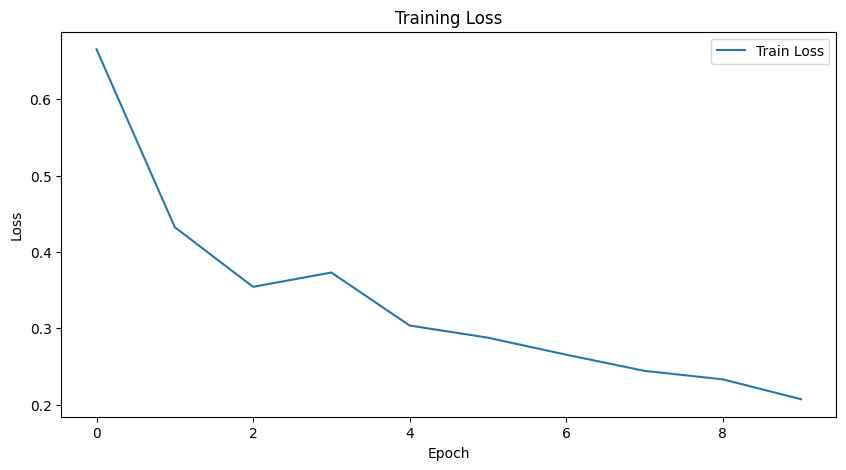

              precision    recall  f1-score   support

      benign       0.94      0.91      0.93       179
   malignant       0.85      0.88      0.87        84
      normal       0.89      0.94      0.92        53

    accuracy                           0.91       316
   macro avg       0.90      0.91      0.90       316
weighted avg       0.91      0.91      0.91       316



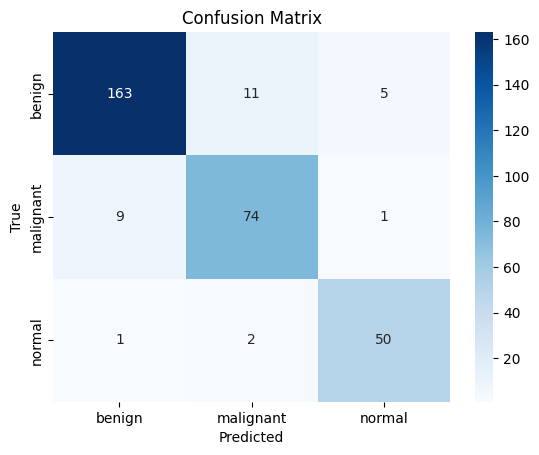

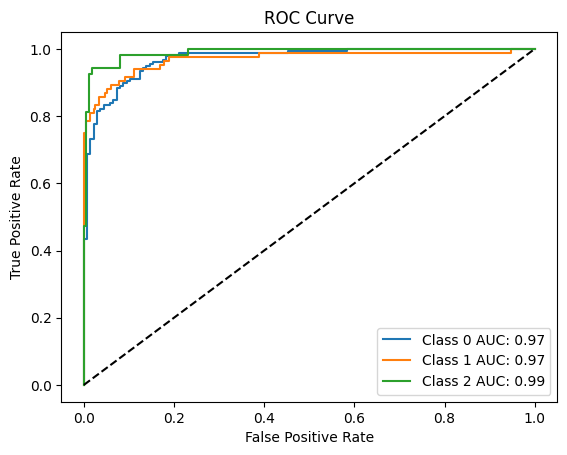

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



🚀 Training EFFICIENTNET_B0...


100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


Epoch 1/10, Loss: 0.5267162602159041
Epoch 2/10, Loss: 0.3624278263577932
Epoch 3/10, Loss: 0.3008234681962412
Epoch 4/10, Loss: 0.24430672025095812
Epoch 5/10, Loss: 0.18546607509208254
Epoch 6/10, Loss: 0.23951647923434083
Epoch 7/10, Loss: 0.1171809920593153
Epoch 8/10, Loss: 0.12525631494442874
Epoch 9/10, Loss: 0.13494987502882752
Epoch 10/10, Loss: 0.10282050928431033


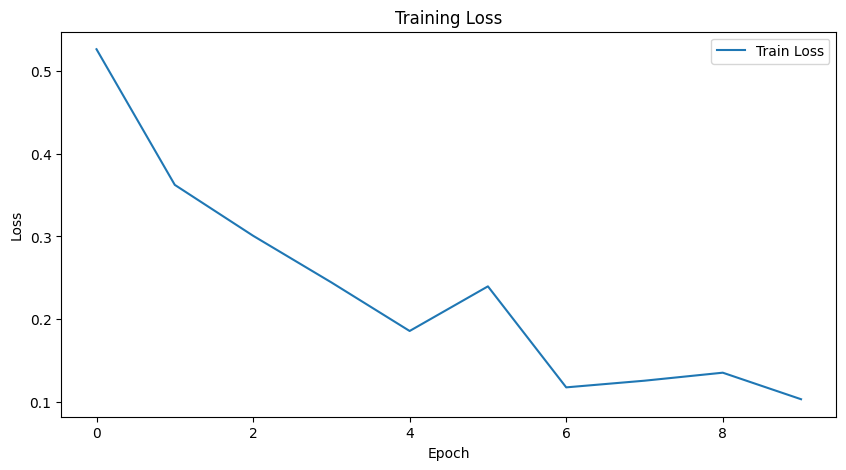

              precision    recall  f1-score   support

      benign       0.94      0.91      0.92       179
   malignant       0.90      0.86      0.88        84
      normal       0.81      0.98      0.89        53

    accuracy                           0.91       316
   macro avg       0.88      0.91      0.90       316
weighted avg       0.91      0.91      0.91       316



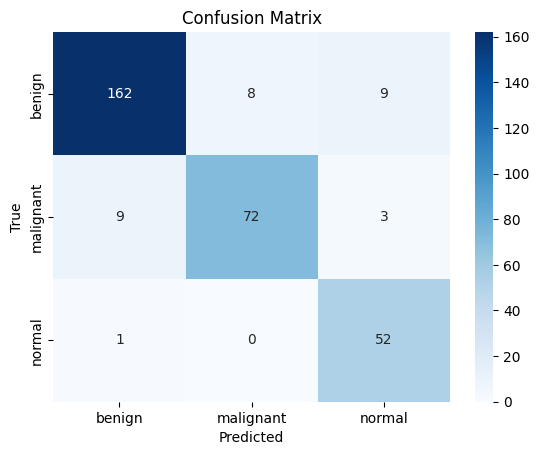

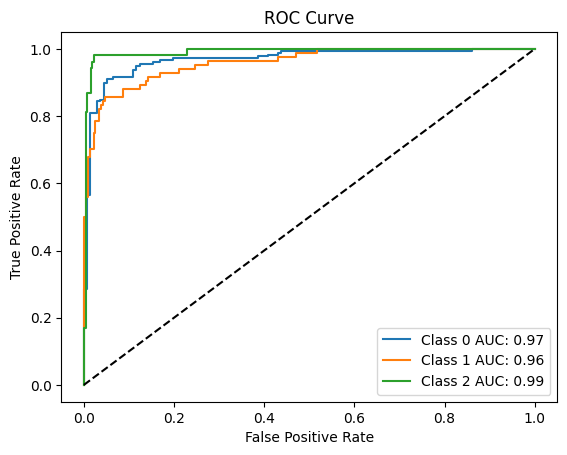


🚀 Training DENSENET121...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s]


Epoch 1/10, Loss: 0.5616828838858423
Epoch 2/10, Loss: 0.46611893969246104
Epoch 3/10, Loss: 0.4036623888377902
Epoch 4/10, Loss: 0.3432766307098202
Epoch 5/10, Loss: 0.32831565455733974
Epoch 6/10, Loss: 0.31503263040433954
Epoch 7/10, Loss: 0.2745956111982276
Epoch 8/10, Loss: 0.26792039778790894
Epoch 9/10, Loss: 0.20801598133071314
Epoch 10/10, Loss: 0.1870903933680133


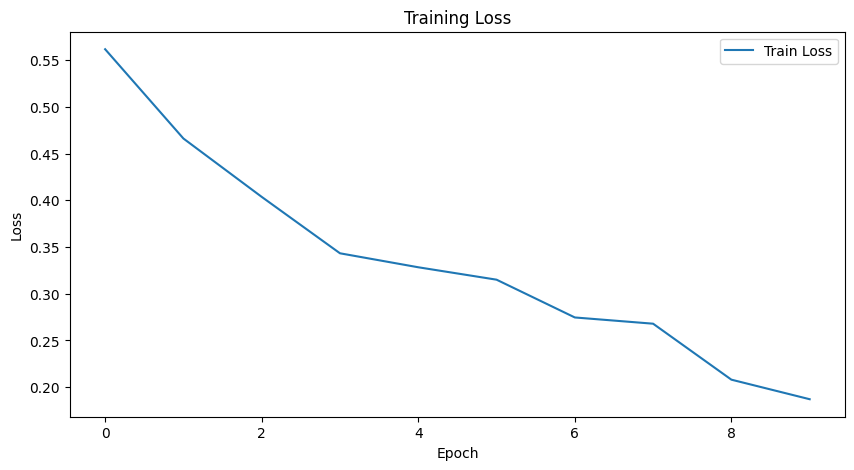

              precision    recall  f1-score   support

      benign       0.93      0.93      0.93       179
   malignant       0.90      0.83      0.86        84
      normal       0.83      0.92      0.88        53

    accuracy                           0.90       316
   macro avg       0.89      0.90      0.89       316
weighted avg       0.90      0.90      0.90       316



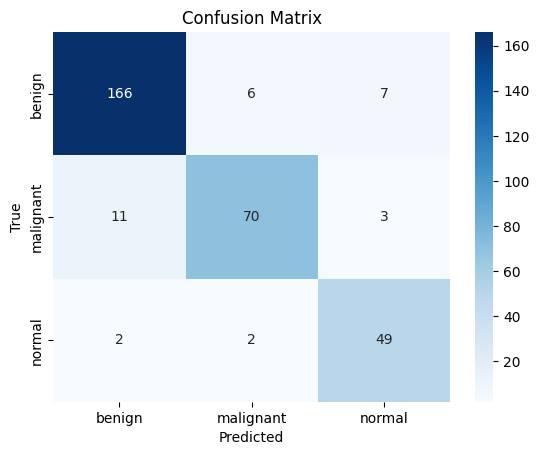

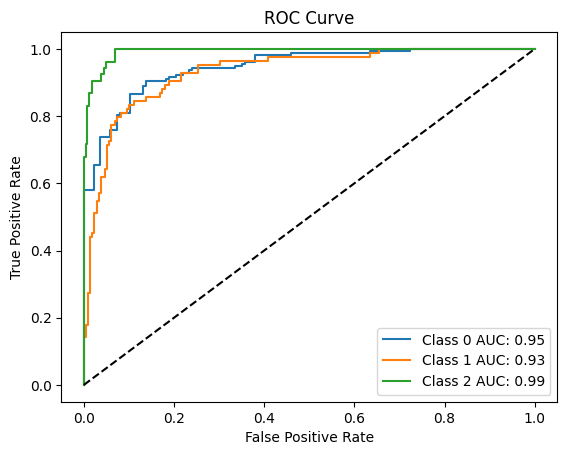

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



🚀 Training MOBILENET_V2...


100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s]


Epoch 1/10, Loss: 0.6011488829986958
Epoch 2/10, Loss: 0.37895416176017327
Epoch 3/10, Loss: 0.346370844524118
Epoch 4/10, Loss: 0.3133908138622212
Epoch 5/10, Loss: 0.1889441854827389
Epoch 6/10, Loss: 0.18382516627117426
Epoch 7/10, Loss: 0.17172548019244702
Epoch 8/10, Loss: 0.13238283138887225
Epoch 9/10, Loss: 0.11355280881317309
Epoch 10/10, Loss: 0.12294173027872096


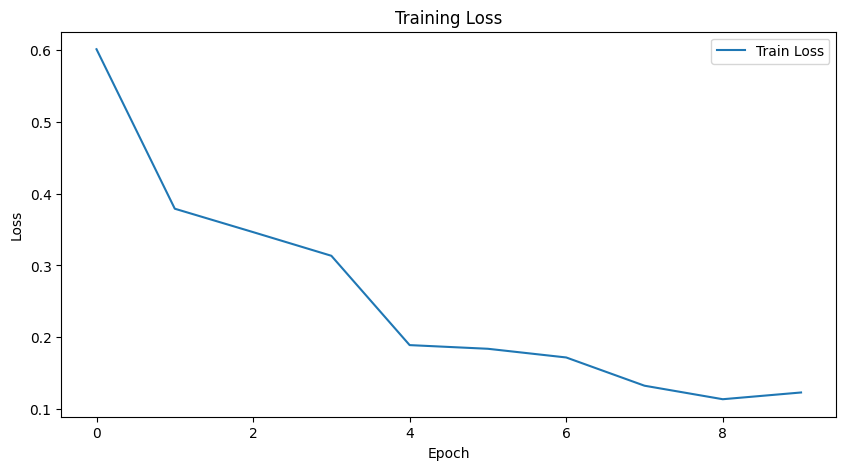

              precision    recall  f1-score   support

      benign       0.93      0.89      0.91       179
   malignant       0.82      0.89      0.86        84
      normal       0.85      0.85      0.85        53

    accuracy                           0.89       316
   macro avg       0.87      0.88      0.87       316
weighted avg       0.89      0.89      0.89       316



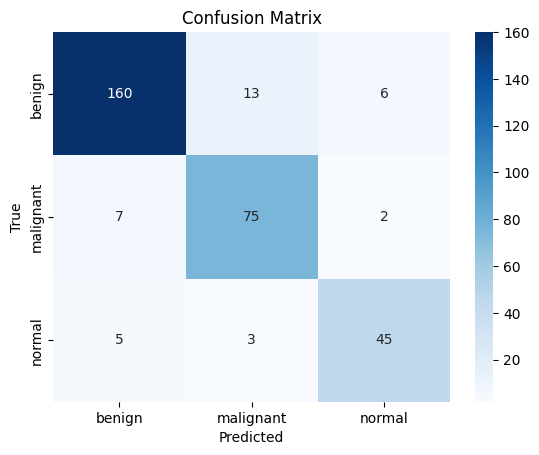

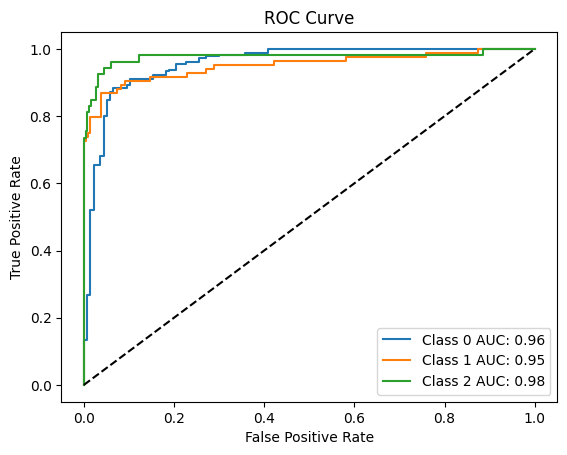

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth



🚀 Training SHUFFLENET_V2_X1_0...


100%|██████████| 8.79M/8.79M [00:00<00:00, 108MB/s]


Epoch 1/10, Loss: 0.6063309977703457
Epoch 2/10, Loss: 0.30045060700253595
Epoch 3/10, Loss: 0.20433247292154952
Epoch 4/10, Loss: 0.13692243510409247
Epoch 5/10, Loss: 0.12213668735297042
Epoch 6/10, Loss: 0.10118411469591569
Epoch 7/10, Loss: 0.08566035819534637
Epoch 8/10, Loss: 0.10873611030887954
Epoch 9/10, Loss: 0.08434247711814846
Epoch 10/10, Loss: 0.07033644054568361


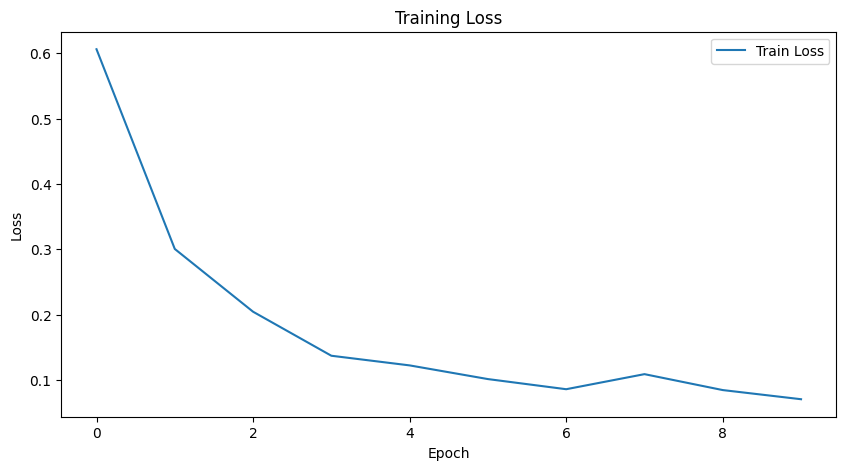

              precision    recall  f1-score   support

      benign       0.94      0.91      0.92       179
   malignant       0.89      0.83      0.86        84
      normal       0.80      0.98      0.88        53

    accuracy                           0.90       316
   macro avg       0.88      0.91      0.89       316
weighted avg       0.90      0.90      0.90       316



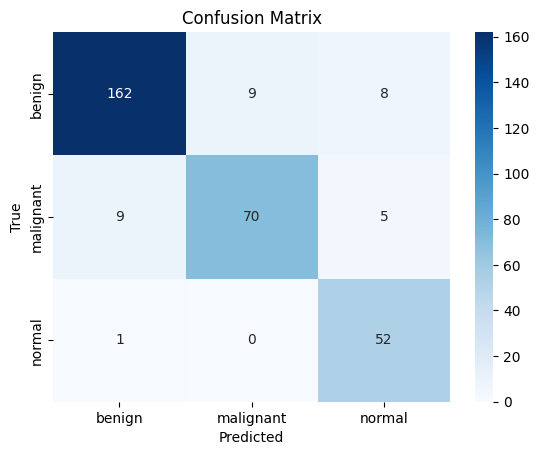

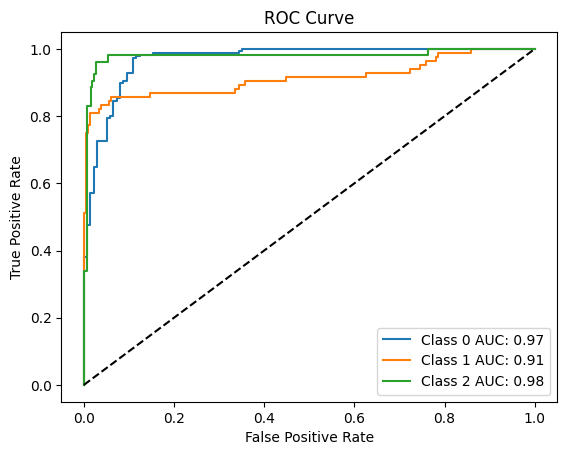

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth



🚀 Training SQUEEZENET1_0...


100%|██████████| 4.78M/4.78M [00:00<00:00, 64.4MB/s]


Epoch 1/10, Loss: 1.0055359639698946
Epoch 2/10, Loss: 0.8937498708314533
Epoch 3/10, Loss: 0.8033109914652908
Epoch 4/10, Loss: 0.7301036538202551
Epoch 5/10, Loss: 0.6926781840716736
Epoch 6/10, Loss: 0.6487164022047308
Epoch 7/10, Loss: 0.5716549007198478
Epoch 8/10, Loss: 0.5290128375533261
Epoch 9/10, Loss: 0.5006746681807916
Epoch 10/10, Loss: 0.4726963627942001


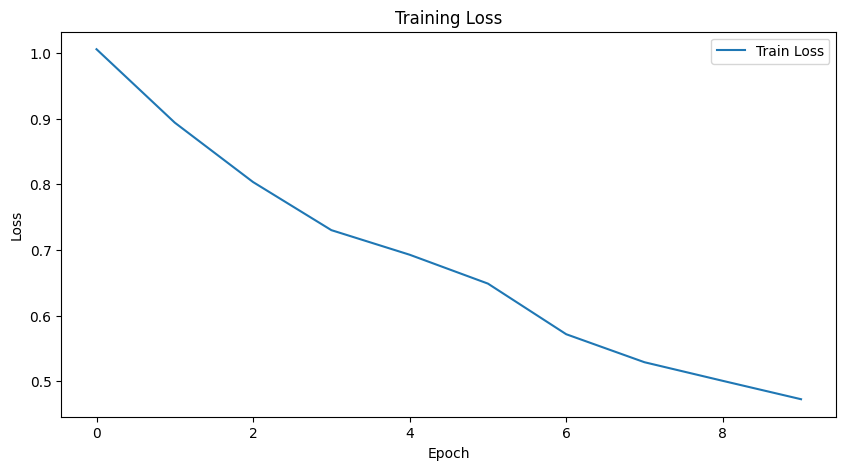

              precision    recall  f1-score   support

      benign       0.72      0.86      0.78       179
   malignant       0.68      0.60      0.63        84
      normal       0.96      0.49      0.65        53

    accuracy                           0.73       316
   macro avg       0.78      0.65      0.69       316
weighted avg       0.75      0.73      0.72       316



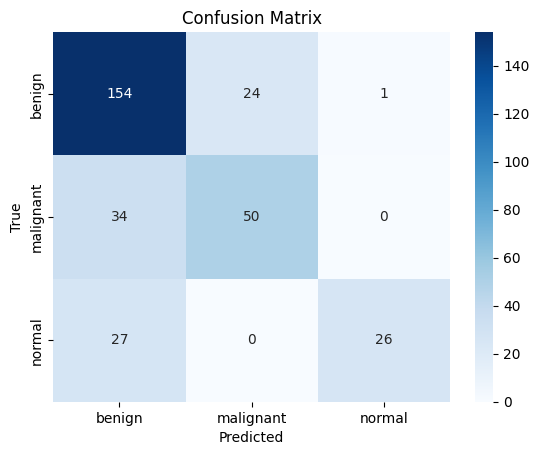

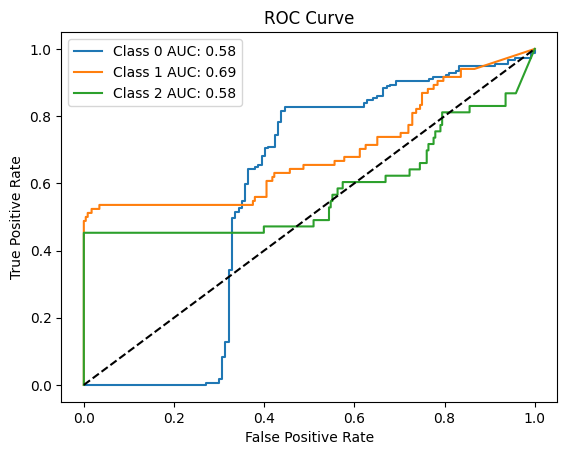


🚀 Training RESNET50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


Epoch 1/10, Loss: 0.7472537448511848
Epoch 2/10, Loss: 0.6220172443721868
Epoch 3/10, Loss: 0.5958305218174488
Epoch 4/10, Loss: 0.5288236949451363
Epoch 5/10, Loss: 0.5489027402068996
Epoch 6/10, Loss: 0.49607205466379095
Epoch 7/10, Loss: 0.4267370084984393
Epoch 8/10, Loss: 0.4399192314359206
Epoch 9/10, Loss: 0.38454775191560575
Epoch 10/10, Loss: 0.35904916922880126


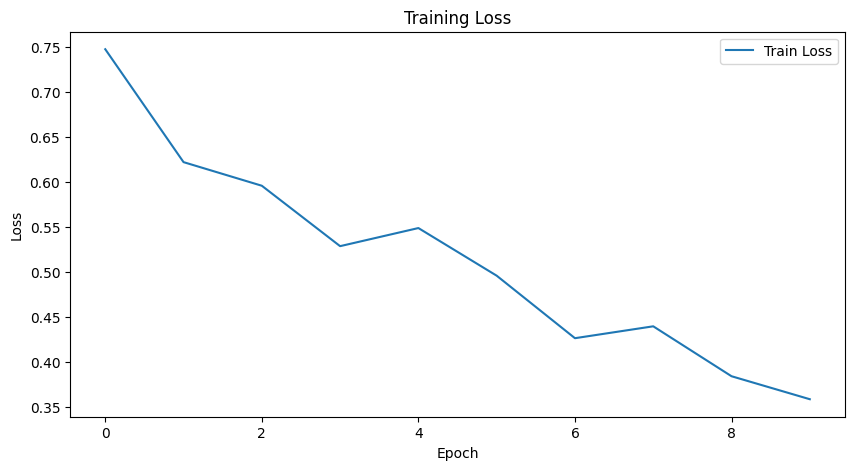

              precision    recall  f1-score   support

      benign       0.86      0.72      0.78       179
   malignant       0.93      0.64      0.76        84
      normal       0.46      0.96      0.63        53

    accuracy                           0.74       316
   macro avg       0.75      0.77      0.72       316
weighted avg       0.82      0.74      0.75       316



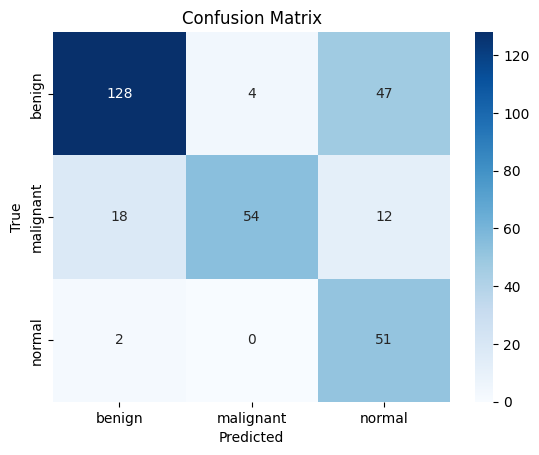

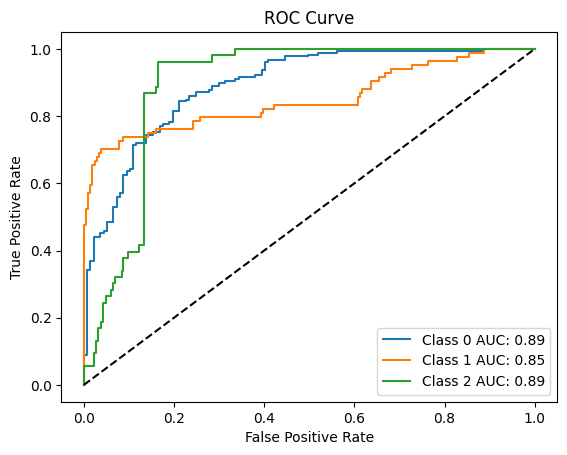


🚀 Training CONVNEXT_TINY...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 135MB/s]


Epoch 1/10, Loss: 1.0186460297318953
Epoch 2/10, Loss: 0.992037361181235
Epoch 3/10, Loss: 0.9777847845343095
Epoch 4/10, Loss: 0.9870554012588307
Epoch 5/10, Loss: 0.9873755611950839
Epoch 6/10, Loss: 0.9887597387350058
Epoch 7/10, Loss: 0.9822120689138581
Epoch 8/10, Loss: 0.9839027689982064
Epoch 9/10, Loss: 0.9818015883240518
Epoch 10/10, Loss: 0.9811451744429672


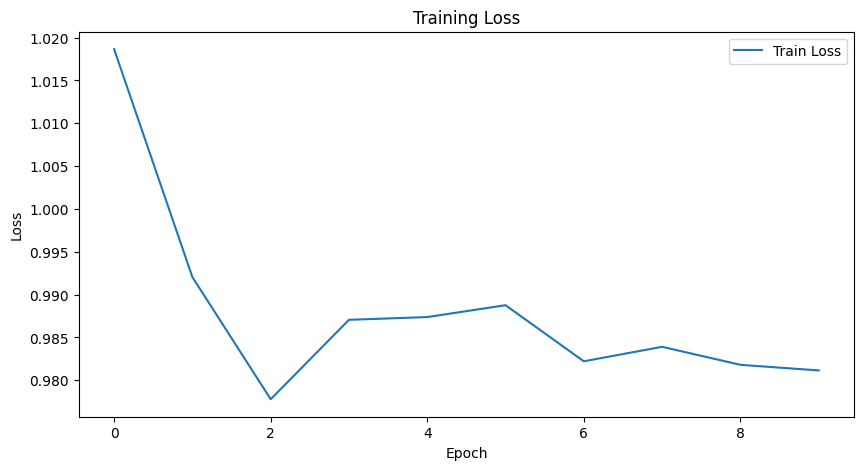

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      benign       0.57      1.00      0.72       179
   malignant       0.00      0.00      0.00        84
      normal       0.00      0.00      0.00        53

    accuracy                           0.57       316
   macro avg       0.19      0.33      0.24       316
weighted avg       0.32      0.57      0.41       316



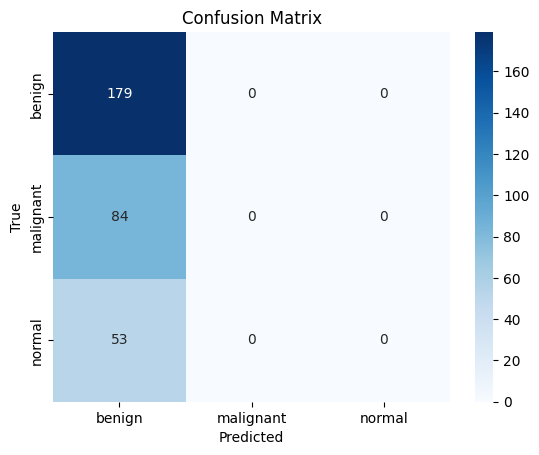

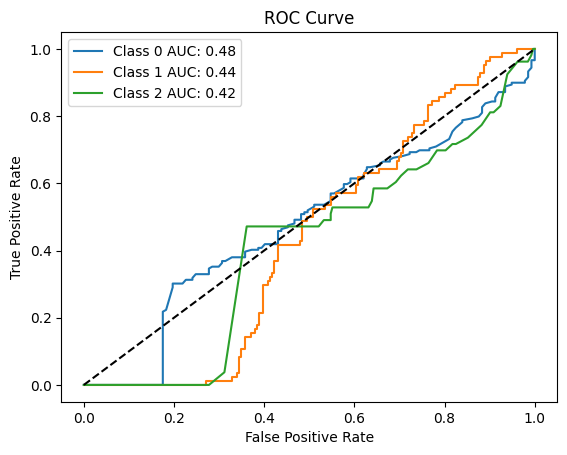

In [ ]:
models_to_train = [
    'resnet18',
    'efficientnet_b0',
    'densenet121',
    'mobilenet_v2',
    'shufflenet_v2_x1_0',
    'squeezenet1_0',
    'resnet50',
    'convnext_tiny'
]

print("📌 Models to be trained:")
for model_name in models_to_train:
    print(f" - {model_name}")

for model_name in models_to_train:
    print(f"\n🚀 Training {model_name.upper()}...")
    model = get_model(model_name)
    train_losses = train_model(model)
    plot_loss(train_losses)
    evaluate_model(model)
    plot_roc(model)



**Get Softmax Probabilities from Each Model
**

In [ ]:
def get_softmax_preds(model, dataloader):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())

    return np.concatenate(all_probs, axis=0)


**Train and Save the Models First**

In [ ]:
torch.save(model.state_dict(), f"{model_name}.pth")



🚀 Training RESNET18...
Epoch 1/10, Loss: 0.651900706411917
Epoch 2/10, Loss: 0.5146470899823345
Epoch 3/10, Loss: 0.3576951223083689
Epoch 4/10, Loss: 0.35524136422178415
Epoch 5/10, Loss: 0.3171454654369928
Epoch 6/10, Loss: 0.3002427500920205
Epoch 7/10, Loss: 0.27799026156433776
Epoch 8/10, Loss: 0.21306565352067164
Epoch 9/10, Loss: 0.1351482412435963
Epoch 10/10, Loss: 0.17821227698999492


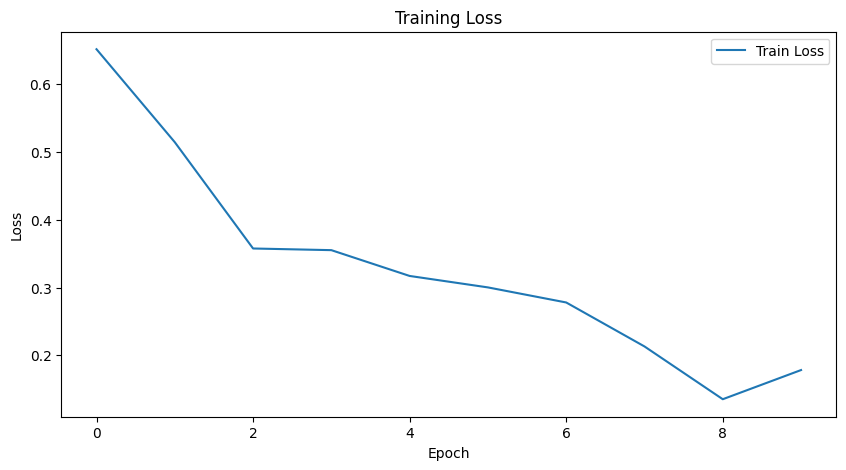

              precision    recall  f1-score   support

      benign       0.98      0.80      0.88       179
   malignant       0.91      0.82      0.86        84
      normal       0.56      1.00      0.72        53

    accuracy                           0.84       316
   macro avg       0.82      0.87      0.82       316
weighted avg       0.89      0.84      0.85       316



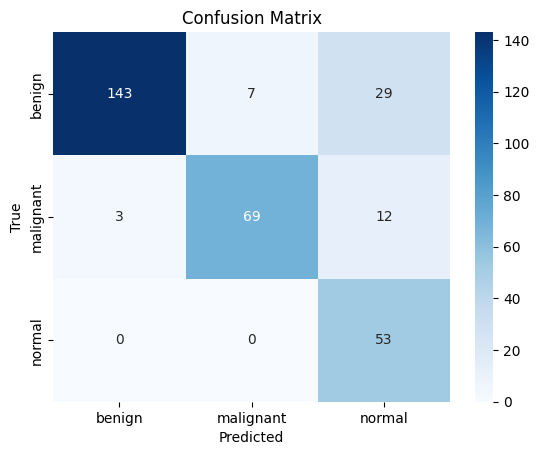

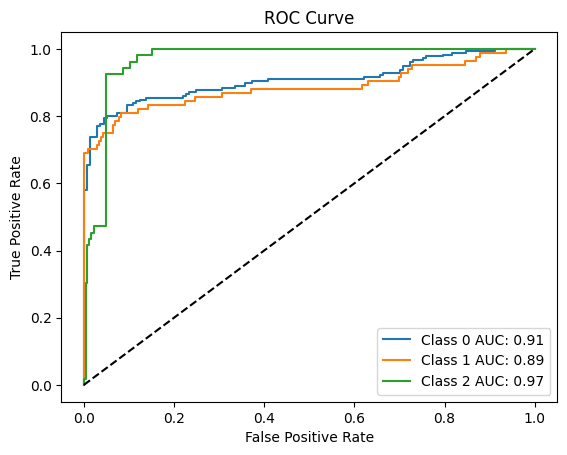


🚀 Training EFFICIENTNET_B0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.5129134390927568
Epoch 2/10, Loss: 0.38485211511201495
Epoch 3/10, Loss: 0.3236665808701817
Epoch 4/10, Loss: 0.21591739104235474
Epoch 5/10, Loss: 0.19888756039870692
Epoch 6/10, Loss: 0.15677040703358908
Epoch 7/10, Loss: 0.14455006000456178
Epoch 8/10, Loss: 0.12364201613442524
Epoch 9/10, Loss: 0.10290400347306947
Epoch 10/10, Loss: 0.11991294797309497


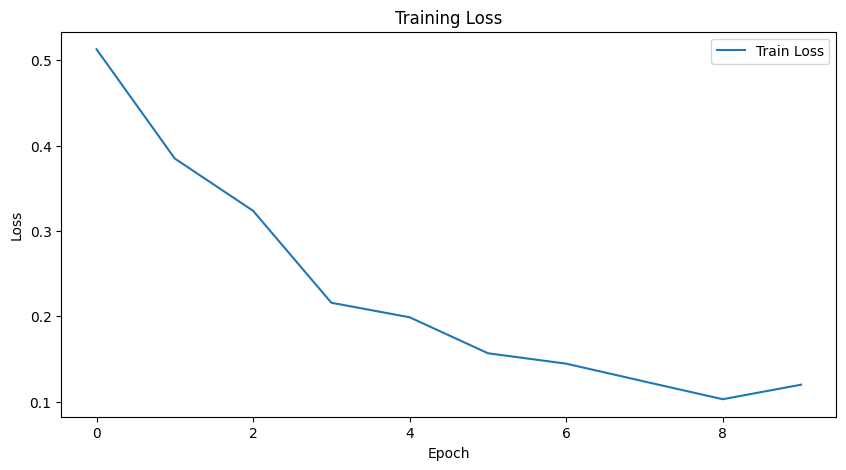

              precision    recall  f1-score   support

      benign       0.91      0.90      0.90       179
   malignant       0.93      0.77      0.84        84
      normal       0.74      0.96      0.84        53

    accuracy                           0.88       316
   macro avg       0.86      0.88      0.86       316
weighted avg       0.89      0.88      0.88       316



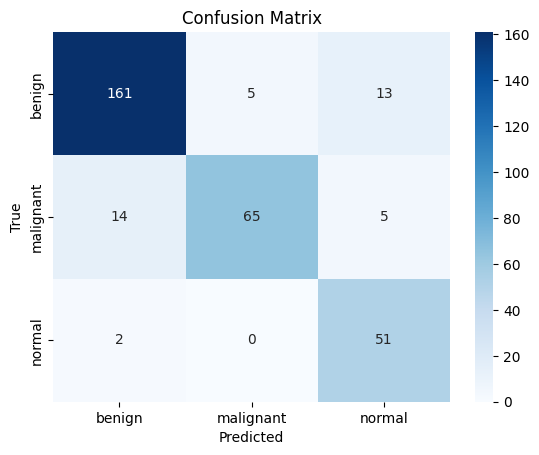

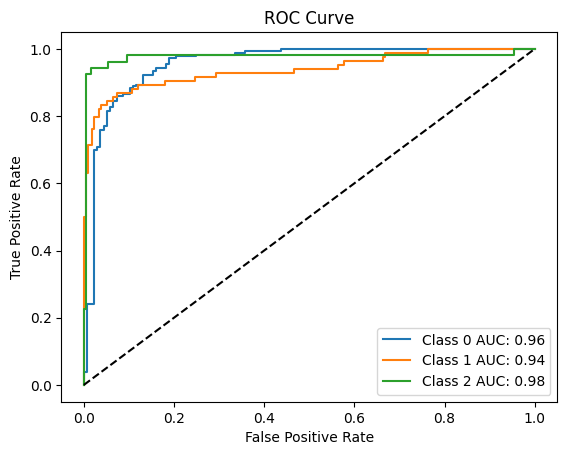


🚀 Training DENSENET121...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.5907826591518861
Epoch 2/10, Loss: 0.4367408169598519
Epoch 3/10, Loss: 0.3813676139504849
Epoch 4/10, Loss: 0.33822724590950376
Epoch 5/10, Loss: 0.3042512252643893
Epoch 6/10, Loss: 0.3076489102802699
Epoch 7/10, Loss: 0.2396336384824937
Epoch 8/10, Loss: 0.2162565143802498
Epoch 9/10, Loss: 0.27583533127002324
Epoch 10/10, Loss: 0.18039280126649368


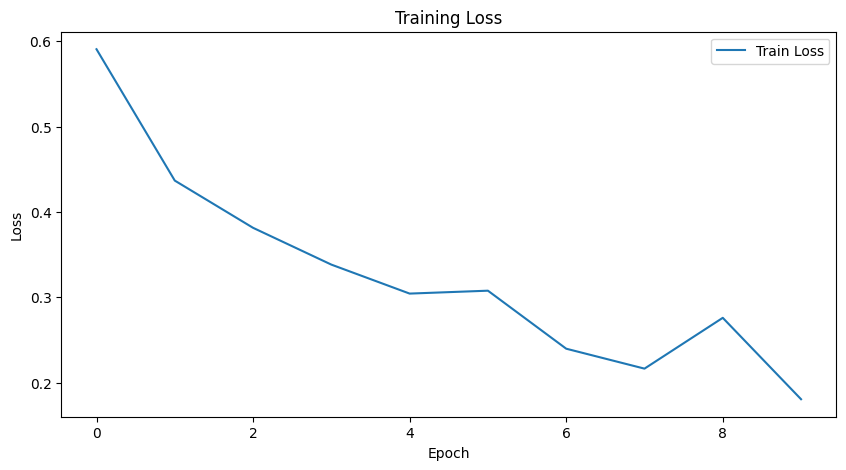

              precision    recall  f1-score   support

      benign       0.93      0.87      0.90       179
   malignant       0.81      0.87      0.84        84
      normal       0.83      0.91      0.86        53

    accuracy                           0.88       316
   macro avg       0.86      0.88      0.87       316
weighted avg       0.88      0.88      0.88       316



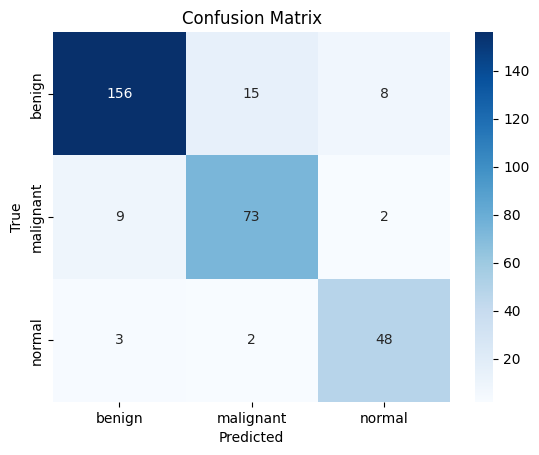

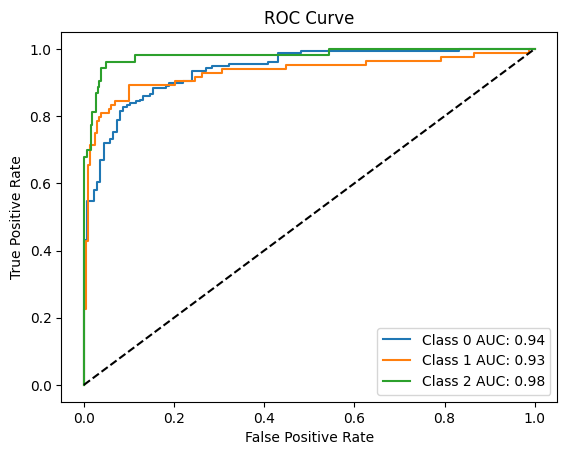


🚀 Training MOBILENET_V2...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.5970896280641798
Epoch 2/10, Loss: 0.36818200783639016
Epoch 3/10, Loss: 0.3149757894062543
Epoch 4/10, Loss: 0.29443878911529914
Epoch 5/10, Loss: 0.24532917358830006
Epoch 6/10, Loss: 0.2690717058515624
Epoch 7/10, Loss: 0.14461713645583654
Epoch 8/10, Loss: 0.1708726263074558
Epoch 9/10, Loss: 0.1521554143651377
Epoch 10/10, Loss: 0.15644758662704047


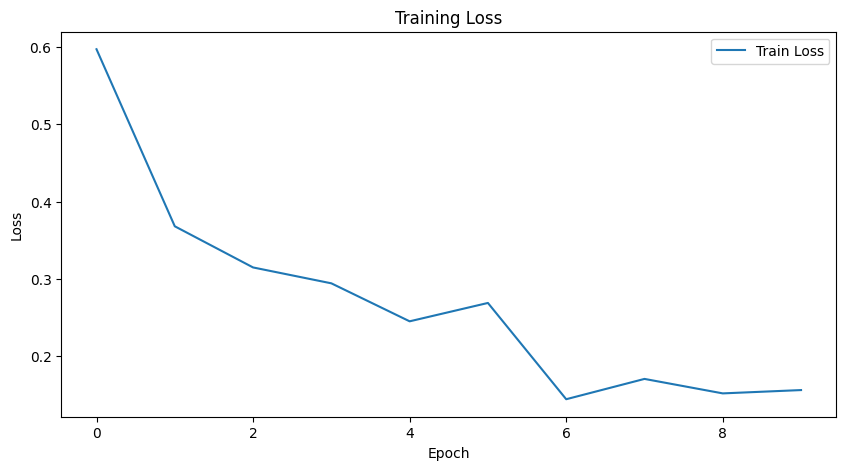

              precision    recall  f1-score   support

      benign       0.89      0.94      0.92       179
   malignant       0.88      0.80      0.84        84
      normal       0.86      0.81      0.83        53

    accuracy                           0.88       316
   macro avg       0.88      0.85      0.86       316
weighted avg       0.88      0.88      0.88       316



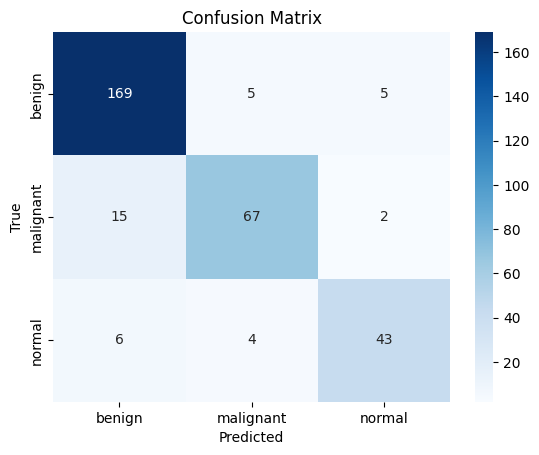

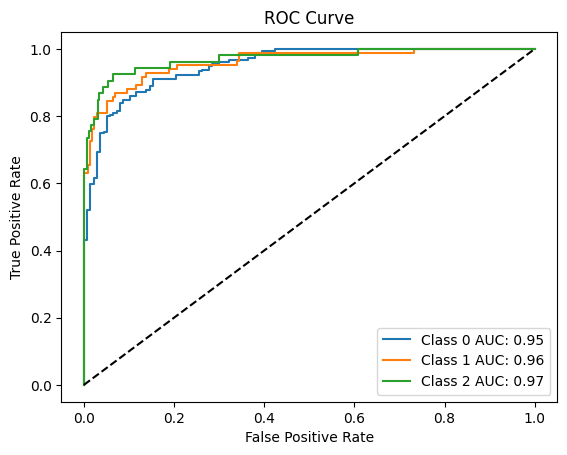


🚀 Training SHUFFLENET_V2_X1_0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.5856312279459797
Epoch 2/10, Loss: 0.32184486072274704
Epoch 3/10, Loss: 0.21643221095392975
Epoch 4/10, Loss: 0.14723487495432927
Epoch 5/10, Loss: 0.11962245366995848
Epoch 6/10, Loss: 0.13760365898237575
Epoch 7/10, Loss: 0.08462344706530057
Epoch 8/10, Loss: 0.06894410007244235
Epoch 9/10, Loss: 0.08573725399755742
Epoch 10/10, Loss: 0.1050041268662184


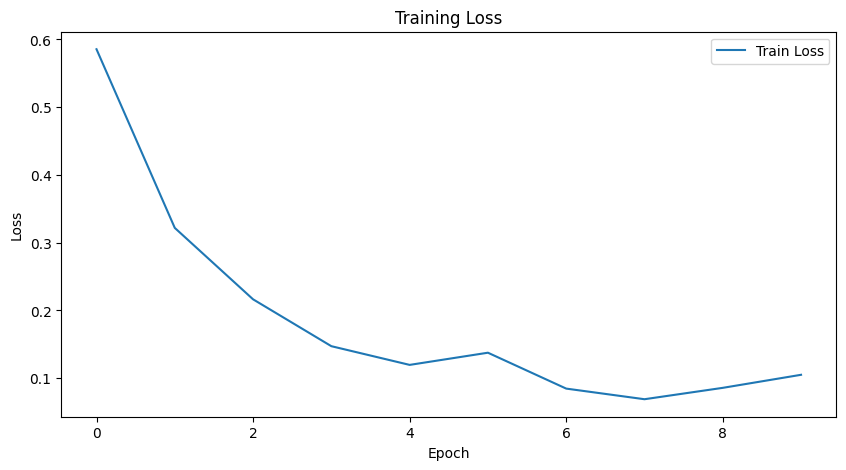

              precision    recall  f1-score   support

      benign       0.96      0.91      0.93       179
   malignant       0.85      0.92      0.88        84
      normal       0.88      0.94      0.91        53

    accuracy                           0.91       316
   macro avg       0.90      0.92      0.91       316
weighted avg       0.92      0.91      0.92       316



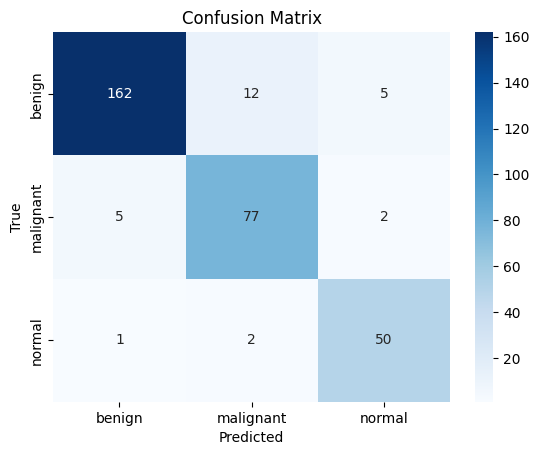

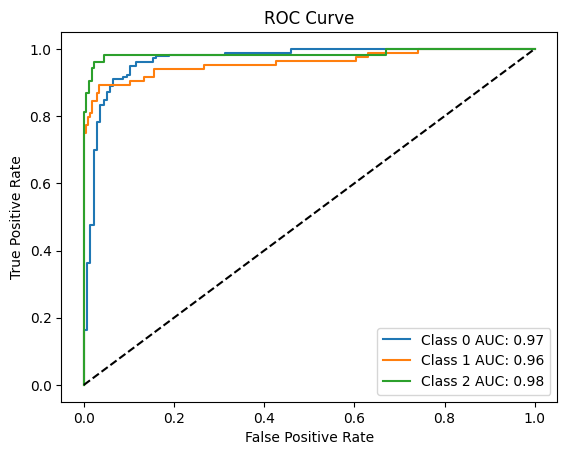


🚀 Training SQUEEZENET1_0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.0146775381474555
Epoch 2/10, Loss: 0.9696929666060435
Epoch 3/10, Loss: 0.9051935868927196
Epoch 4/10, Loss: 0.8753870095633254
Epoch 5/10, Loss: 0.7371006698548039
Epoch 6/10, Loss: 0.618533399663394
Epoch 7/10, Loss: 0.564852350120303
Epoch 8/10, Loss: 0.55840783443632
Epoch 9/10, Loss: 0.530187792227238
Epoch 10/10, Loss: 0.49087561082236375


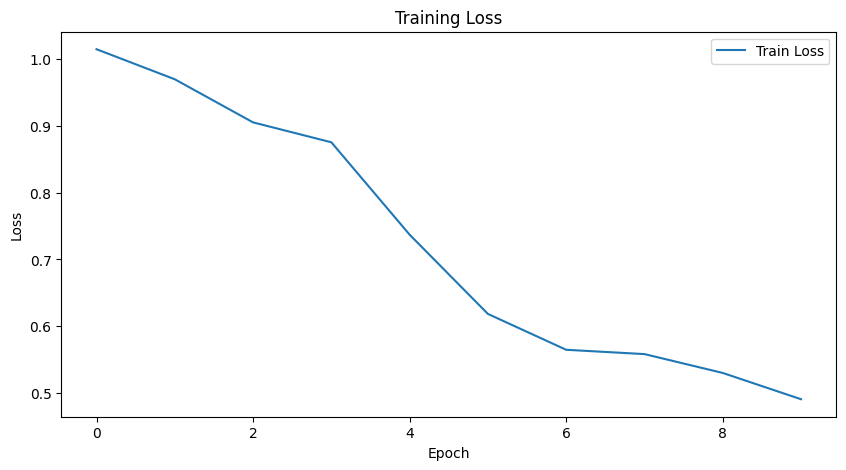

              precision    recall  f1-score   support

      benign       0.90      0.77      0.83       179
   malignant       0.87      0.63      0.73        84
      normal       0.49      0.92      0.64        53

    accuracy                           0.76       316
   macro avg       0.75      0.78      0.73       316
weighted avg       0.82      0.76      0.77       316



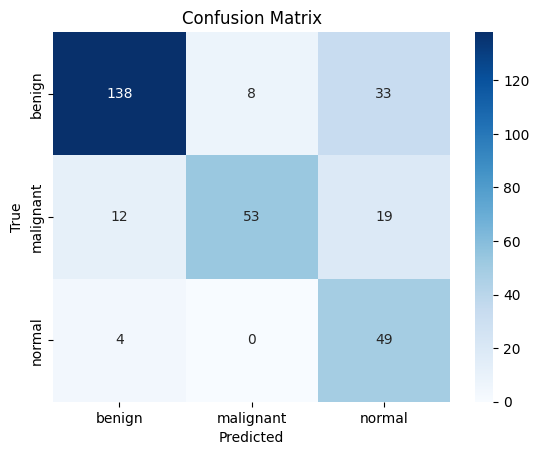

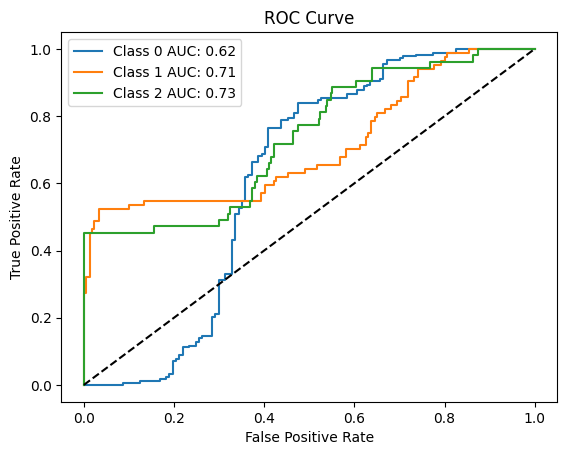


🚀 Training RESNET50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.7792048080812527
Epoch 2/10, Loss: 0.7326326253293436
Epoch 3/10, Loss: 0.6615903366215622
Epoch 4/10, Loss: 0.6134308997211577
Epoch 5/10, Loss: 0.5758286444823953
Epoch 6/10, Loss: 0.6440117621346365
Epoch 7/10, Loss: 0.577472997617118
Epoch 8/10, Loss: 0.5267854163163825
Epoch 9/10, Loss: 0.4819247247297553
Epoch 10/10, Loss: 0.4517917352009423


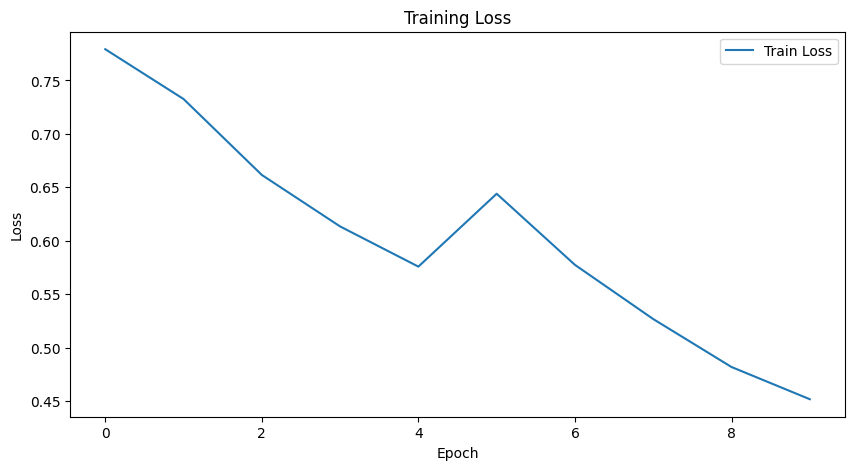

              precision    recall  f1-score   support

      benign       0.74      0.98      0.85       179
   malignant       0.93      0.62      0.74        84
      normal       0.96      0.45      0.62        53

    accuracy                           0.79       316
   macro avg       0.88      0.68      0.73       316
weighted avg       0.83      0.79      0.78       316



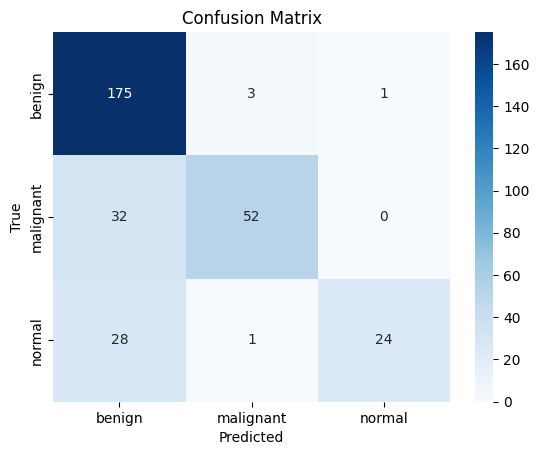

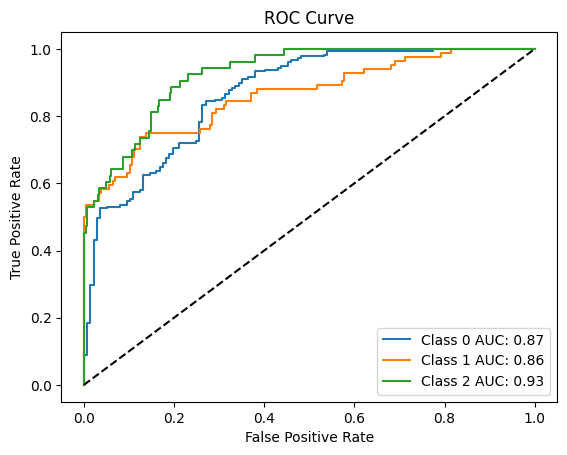


🚀 Training CONVNEXT_TINY...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.0254559720618814
Epoch 2/10, Loss: 0.9848850346818755
Epoch 3/10, Loss: 0.9801962639712081
Epoch 4/10, Loss: 0.9866610855995854
Epoch 5/10, Loss: 0.9806608346444142
Epoch 6/10, Loss: 0.9857747947113423
Epoch 7/10, Loss: 0.9805038556267943
Epoch 8/10, Loss: 0.9851507129548471
Epoch 9/10, Loss: 0.9802297738533986
Epoch 10/10, Loss: 0.9819745866558219


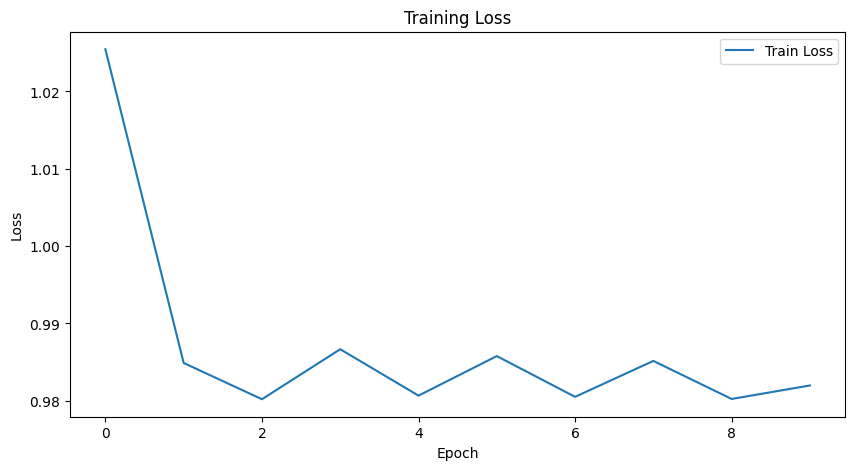

              precision    recall  f1-score   support

      benign       0.57      1.00      0.72       179
   malignant       0.00      0.00      0.00        84
      normal       0.00      0.00      0.00        53

    accuracy                           0.57       316
   macro avg       0.19      0.33      0.24       316
weighted avg       0.32      0.57      0.41       316



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


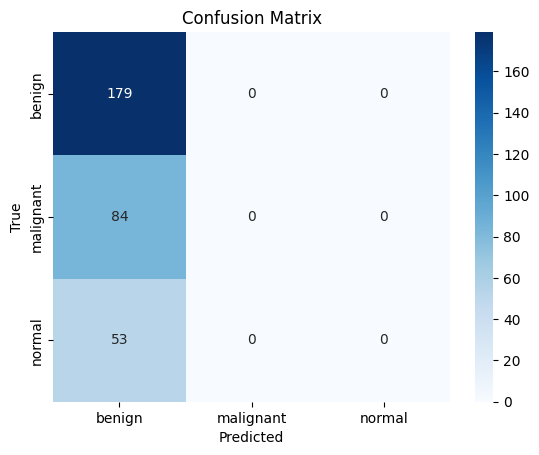

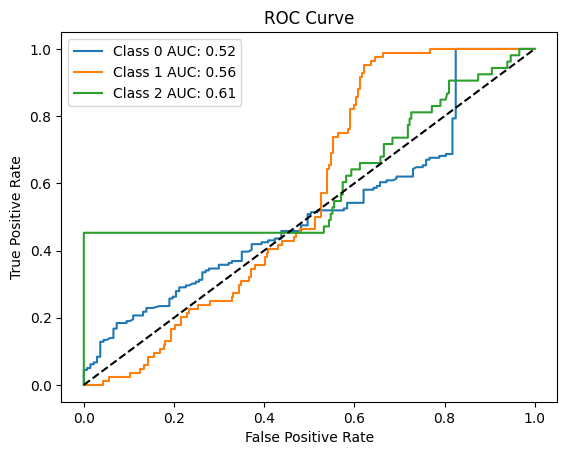

In [ ]:
for model_name in models_to_train:
    print(f"\n🚀 Training {model_name.upper()}...")
    model = get_model(model_name)
    train_losses = train_model(model)
    plot_loss(train_losses)

    # ✅ Save the trained model
    torch.save(model.state_dict(), f"{model_name}.pth")

    evaluate_model(model)
    plot_roc(model)


In [ ]:
import os

if os.path.exists(f"{model_name}.pth"):
    model.load_state_dict(torch.load(f"{model_name}.pth"))
else:
    print(f"⚠️ Warning: {model_name}.pth not found, skipping load.")


**Collect Predictions from All Models**

In [ ]:
all_probs = []

for model_name in models_to_train:
    print(f"Evaluating {model_name}")
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"{model_name}.pth"))  # if saved
    model.eval()
    probs = get_softmax_preds(model, test_loader)
    all_probs.append(probs)


Evaluating resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating efficientnet_b0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating densenet121


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating mobilenet_v2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating shufflenet_v2_x1_0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating squeezenet1_0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating resnet50


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating convnext_tiny


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Average Probabilities and Final Prediction**

In [ ]:
ensemble_probs = np.mean(all_probs, axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)


**Add This Utility to Get True Labels**

In [ ]:
def get_true_labels(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())
    return np.array(all_labels)


In [ ]:
test_labels = get_true_labels(test_loader)


In [ ]:
print("Confusion Matrix (Ensemble):")
print(confusion_matrix(test_labels, ensemble_preds))

print("\nClassification Report (Ensemble):")
print(classification_report(test_labels, ensemble_preds))


Confusion Matrix (Ensemble):
[[168   4   7]
 [ 10  72   2]
 [  1   0  52]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       179
           1       0.95      0.86      0.90        84
           2       0.85      0.98      0.91        53

    accuracy                           0.92       316
   macro avg       0.91      0.93      0.92       316
weighted avg       0.93      0.92      0.92       316



In [ ]:
# Get true labels
test_labels = get_true_labels(test_loader)

# Evaluate ensemble
print("Confusion Matrix (Ensemble):")
print(confusion_matrix(test_labels, ensemble_preds))

print("\nClassification Report (Ensemble):")
print(classification_report(test_labels, ensemble_preds))


Confusion Matrix (Ensemble):
[[168   4   7]
 [ 10  72   2]
 [  1   0  52]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       179
           1       0.95      0.86      0.90        84
           2       0.85      0.98      0.91        53

    accuracy                           0.92       316
   macro avg       0.91      0.93      0.92       316
weighted avg       0.93      0.92      0.92       316



**Evaluate the Ensemble**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix (Ensemble):")
print(confusion_matrix(test_labels, ensemble_preds))

print("\nClassification Report (Ensemble):")
print(classification_report(test_labels, ensemble_preds))


Confusion Matrix (Ensemble):
[[168   4   7]
 [ 10  72   2]
 [  1   0  52]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       179
           1       0.95      0.86      0.90        84
           2       0.85      0.98      0.91        53

    accuracy                           0.92       316
   macro avg       0.91      0.93      0.92       316
weighted avg       0.93      0.92      0.92       316



**Weighted Ensemble**

In [ ]:
weights = [0.1, 0.15, 0.2, 0.2, 0.15, 0.1, 0.05, 0.05]  # sum to 1
ensemble_probs = np.average(all_probs, axis=0, weights=weights)


**Define the Hybrid Model**

In [ ]:
import torch.nn as nn
import torchvision.models as models

class HybridFeatureFusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridFeatureFusionModel, self).__init__()

        # Base Model 1: ResNet18
        self.resnet = models.resnet18(pretrained=True)
        self.resnet_fc_features = self.resnet.fc.in_features
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # remove last FC

        # Base Model 2: EfficientNetB0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_fc_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.features = self.efficientnet.features  # keep only feature extractor

        # Custom FC Layer for EfficientNet
        self.eff_avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Combined Feature Dimension
        total_features = self.resnet_fc_features + self.efficientnet_fc_features

        # Classifier on concatenated features
        self.classifier = nn.Sequential(
            nn.Linear(total_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract features from ResNet
        resnet_feat = self.resnet(x)
        resnet_feat = resnet_feat.view(resnet_feat.size(0), -1)

        # Extract features from EfficientNet
        eff_feat = self.efficientnet.features(x)
        eff_feat = self.eff_avgpool(eff_feat)
        eff_feat = eff_feat.view(eff_feat.size(0), -1)

        # Concatenate features
        combined_feat = torch.cat((resnet_feat, eff_feat), dim=1)

        # Classify
        out = self.classifier(combined_feat)
        return out


**Train the Hybrid Model**

In [ ]:
model = HybridFeatureFusionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most u

**Train Loop (Reuse Existing One)**

Epoch 1/10, Loss: 0.6262011622326283
Epoch 2/10, Loss: 0.4416800609117822
Epoch 3/10, Loss: 0.33803782112236264
Epoch 4/10, Loss: 0.3124986288102367
Epoch 5/10, Loss: 0.2636108733006293
Epoch 6/10, Loss: 0.24589633671684732
Epoch 7/10, Loss: 0.1841611840667887
Epoch 8/10, Loss: 0.14474941691961377
Epoch 9/10, Loss: 0.184219869655333
Epoch 10/10, Loss: 0.15503130485657365


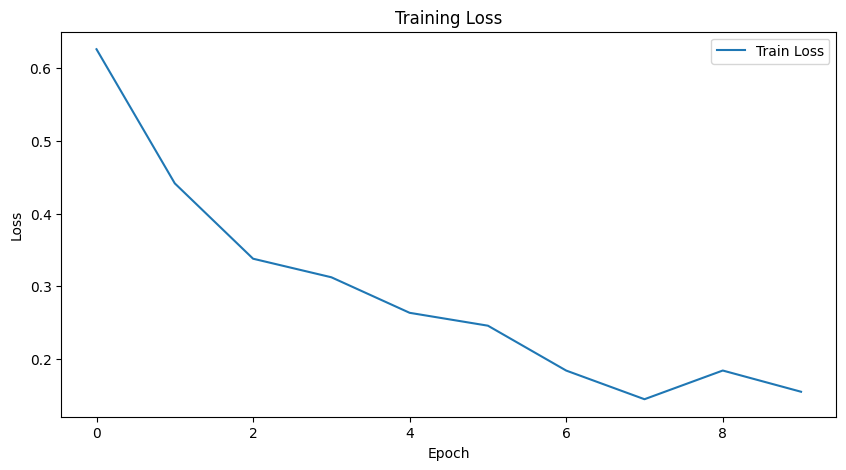

              precision    recall  f1-score   support

      benign       0.92      0.92      0.92       179
   malignant       0.77      0.83      0.80        84
      normal       0.91      0.79      0.85        53

    accuracy                           0.88       316
   macro avg       0.87      0.85      0.86       316
weighted avg       0.88      0.88      0.88       316



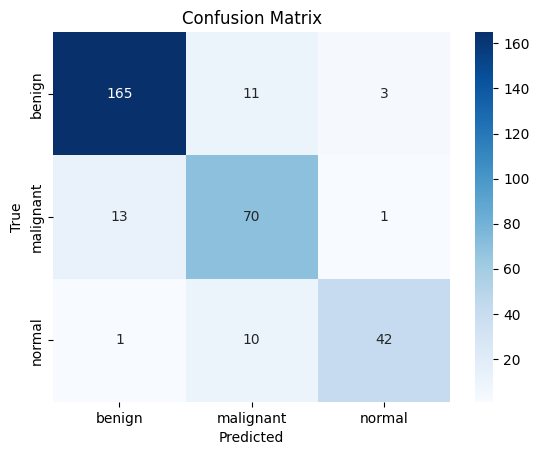

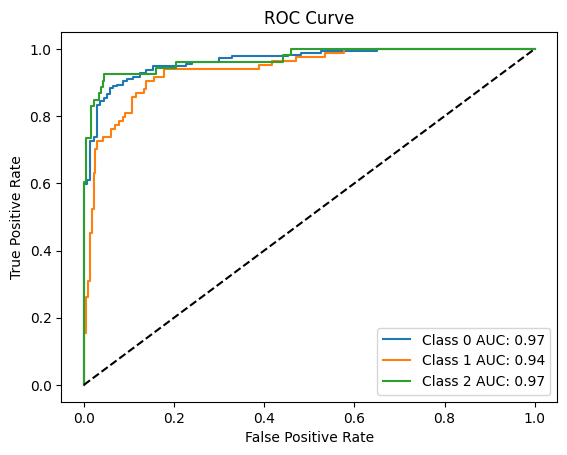

In [ ]:
train_losses = train_model(model)
plot_loss(train_losses)
evaluate_model(model)
plot_roc(model)


**Save the Model**

In [ ]:
torch.save(model.state_dict(), "hybrid_feature_fusion.pth")


**Create a Function to Get Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

def get_accuracy(model, dataloader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return accuracy_score(labels, preds)


**Evaluate All Models and Store Results**

In [ ]:
model_accuracies = {}

for model_name in models_to_train:
    print(f"Evaluating accuracy of {model_name}...")
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"{model_name}.pth"))
    model = model.to(device)
    acc = get_accuracy(model, test_loader)
    model_accuracies[model_name] = acc


Evaluating accuracy of resnet18...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of efficientnet_b0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of densenet121...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of mobilenet_v2...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of shufflenet_v2_x1_0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of squeezenet1_0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of resnet50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating accuracy of convnext_tiny...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Add Ensemble Accuracy**

In [ ]:
ensemble_acc = accuracy_score(test_labels, ensemble_preds)
model_accuracies["ensemble"] = ensemble_acc


**Display as a Table**

In [ ]:
import pandas as pd

accuracy_table = pd.DataFrame(list(model_accuracies.items()), columns=["Model", "Accuracy"])
accuracy_table = accuracy_table.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print(accuracy_table)


                Model  Accuracy
0            ensemble  0.924051
1  shufflenet_v2_x1_0  0.914557
2        mobilenet_v2  0.882911
3     efficientnet_b0  0.876582
4         densenet121  0.876582
5            resnet18  0.838608
6            resnet50  0.794304
7       squeezenet1_0  0.759494
8       convnext_tiny  0.566456
